In [1]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pencil as pc
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid as trap
import modes
from IPython.display import display, Latex

         pencil has moved to pencil_old.
To change your scripts accordingly:
import pencilnew as pc -> import pencil as pc
import pencil as pc -> import pencil_old as pc


In [ ]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['text.usetex'] = True

In [ ]:
sim = pc.get_sim(quiet=True)
ts = pc.read.ts()
yaver = pc.read.aver(plane_list='y')
xyaver = pc.read.aver(plane_list=['xy'])

Read 16076 lines.


In [ ]:
class Phase(modes.Modes):
    """
    To analyze different phases
    """

    def __init__(self, path, t1, t2, z_ref, norm, sim, ts, xyaver, yaver, ini=False, dyn=True):
        super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=True)

        self.path = path
        self.t = self.yaver.t
        self.z_ref = z_ref
        self.norm = norm

        self.kf = super().get_kf()
        self.indx_t1 = np.argmin(np.abs(self.yaver.t-t1))
        self.indx_t2 = np.argmin(np.abs(self.yaver.t-t2))

        self.uz_real = self.yaver.y.uzmxz[self.indx_t1:self.indx_t2,:,self.z_ref]
        self.uz_fourier = super().FT(self.uz_real, self.norm)
        # self.uz_fourier = super().FT(self.uz_real, 'ortho')
        self.log_P = super().logP(self.uz_fourier, self.d)
        self.om_til = super().omega_tilde(self.indx_t1, self.indx_t2)
        self.k_til = super().k_tilde()
        self.upto_indx = super().upto(self.indx_t1, self.indx_t2)

    def indx_k(self, k_xtil:np.ndarray):
        indx = np.argmin(np.abs(self.k_til-k_xtil))
        return indx
    
    def Power(self, indx:int):
        P = np.exp(self.log_P[:self.upto_indx,indx])
        return P
    
    def Power_filtered(self, power:np.ndarray, sigma):
        P_filt = gaussian_filter(power[:self.upto_indx],sigma)
        return P_filt
    
    def f_freq(self, k_tilx):
        # freq = round(self.fmodes(k_tilx),3)
        freq = self.fmodes(k_tilx)
        return freq
    
    def p_freq(self, k_tilx, num):
        if isinstance(num, int):
            freq = round(self.pmodes(k_tilx,num),3)
        if isinstance(num, list):
            freq=[]
            for i in range(len(num)):
                freq.append(self.pmodes(k_tilx,i))
        return freq
    
    def plot(self, ax, P:np.ndarray, **kwargs):
        ax.plot(self.om_til[:self.upto_indx], P, **kwargs)
        # ax.grid()
        # ax.set_ylim(0,)
        ax.legend()

    def xlim(self, x_data:np.ndarray):
        min = x_data[0]
        max = x_data[-1]
        return (min,max)
    
    def cs_du(self, k_tilx):
        csd = self.cs_d*k_tilx/(self.L0*self.omega0)
        csu = self.cs_u*k_tilx/(self.L0*self.omega0)
        return (csd, csu)


    pass

In [ ]:
path = './plots/'

In [ ]:
kinematic = Phase(path, 100, 1500, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)
saturated = Phase(path, 2905, 4305, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)

Have you included bx2mz and by2mz in xyaver.in?
Have you included bx2mz and by2mz in xyaver.in?


In [ ]:
indx_kin = []
indx_sat = []

for i in [1,3,5]:
    indx_kin.append(kinematic.indx_k(i))
    indx_sat.append(saturated.indx_k(i))

In [ ]:
kinematic.k_til[indx_kin]

array([0.78696896, 3.14787584, 4.72181376])

In [ ]:
P_kin = kinematic.Power(indx_kin).T
P_sat = saturated.Power(indx_sat).T
P_kin_filt = kinematic.Power_filtered(P_kin,3)
P_sat_filt = saturated.Power_filtered(P_sat,3)

In [ ]:
np.shape(P_kin_filt)

(3, 1751)

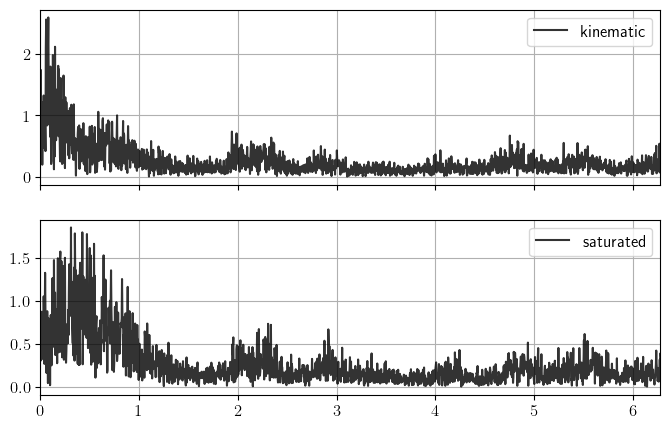

In [ ]:
# fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))#sharex=True,
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))#sharex=True,

# kinematic.plot(axs[0], P_kin, c='k', alpha=0.4, label='kinematic')

kinematic.plot(axs[0], P_kin[2], label='kinematic', c='k', alpha=0.8)
# kinematic.plot(axs[0], P_kin_filt[3], label='filtered')
saturated.plot(axs[1], P_sat[2], label='saturated', c='k', alpha=0.8)
# saturated.plot(axs[1], P_sat_filt[3], label='filtered')

# axs[1].set_xlim(0,kinematic.om_til[kinematic.upto_indx-1])
axs[1].set_xlim(kinematic.xlim(kinematic.om_til[:kinematic.upto_indx-1]))
# axs[1].set_ylim(0,1.75)
axs[0].grid()
axs[1].grid()

In [ ]:
f_om = kinematic.f_freq(kinematic.k_til[indx_kin])
f_om

array([0.886, 1.772, 2.171])

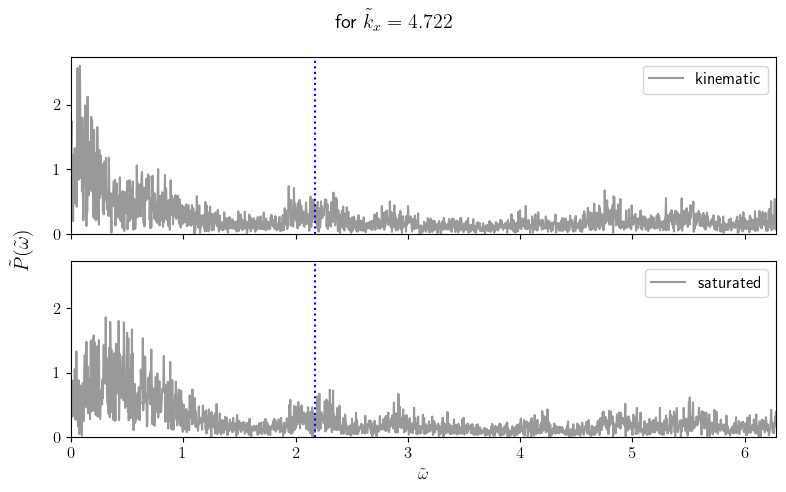

In [ ]:
indx = 2
fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))#sharex=True,

kinematic.plot(axs[0], P_kin[indx], c='k', alpha=0.4, label='kinematic')
# kinematic.plot(axs[0], P_kin_filt[indx], c='C1', label='filtered')
axs[0].axvline(x=f_om[indx], ls=':', c='b')

axs[1].set_xlim(kinematic.xlim(kinematic.om_til[:kinematic.upto_indx-1]))
axs[0].set_ylim(0,)
axs[0].legend()

saturated.plot(axs[1], P_sat[indx], c='k', alpha=0.4, label='saturated')
# saturated.plot(axs[1], P_sat_filt[indx], c='C1', label='filtered')
axs[1].axvline(x=f_om[indx], ls=':', c='b')

axs[1].set_ylim(0,)
axs[1].legend()

plt.xlabel(r"$\tilde{\omega}$")
fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(fr"for $\tilde{{k}}_x={round(kinematic.k_til[indx_kin][indx], 3)}$")
#plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
om_kin = kinematic.om_til[:kinematic.upto_indx]
# indx_f = np.argmin(np.abs(om_kin-f_om))
idl_f_kin = []
idu_f_kin = []
P_f_kin = []
om_f_kin = []

d = [0.65, 0.9, 1.6]
u = [1.20, 2.2, 2.8]

for i in range(3):
    idl_f_kin.append(np.argmin(np.abs(om_kin - d[i])))
    idu_f_kin.append(np.argmin(np.abs(om_kin - u[i])))

    P_f_kin.append(P_kin[i, idl_f_kin[i]:idu_f_kin[i]])
    om_f_kin.append(om_kin[idl_f_kin[i]:idu_f_kin[i]])

In [ ]:
len(om_f_kin[0])

153

In [ ]:
np.shape(P_kin)

(3, 1751)

In [ ]:
# np.shape(P_f_kin)
len(P_f_kin[0])

153

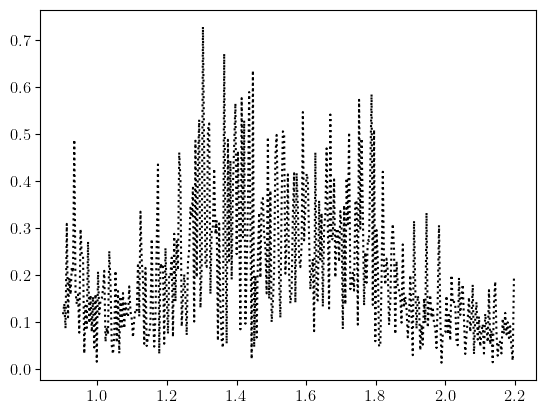

In [ ]:
plt.plot(om_f_kin[1], P_f_kin[1], c='k', ls=':')

In [ ]:
om_sat = saturated.om_til[:saturated.upto_indx]
# indx_f = np.argmin(np.abs(om_sat-f_om))
idl_f_sat = []
idu_f_sat = []
P_f_sat = []
om_f_sat = []

d = [0.71, 0.9, 1.6]
u = [1.24, 2.2, 2.8]

for i in range(3):
    idl_f_sat.append(np.argmin(np.abs(om_sat - d[i])))
    idu_f_sat.append(np.argmin(np.abs(om_sat - u[i])))

    P_f_sat.append(P_sat[i, idl_f_sat[i]:idu_f_sat[i]])
    om_f_sat.append(om_sat[idl_f_sat[i]:idu_f_sat[i]])

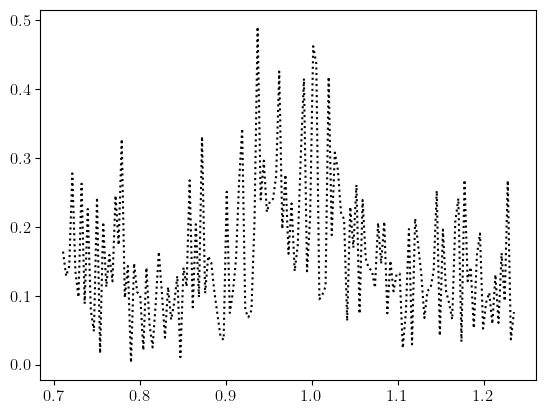

In [ ]:
plt.plot(om_f_sat[0], P_f_sat[0], c='k', ls=':')

In [ ]:
def lorentzian(x, a, b, c, d, e):
    y = a/((x-b)**2+np.exp(c))+d+e*x
    return y

In [ ]:
f_kin = []
f_sat = []
para_f_kin = []

a_kin = [0.6, 0.4, 0.4]
b_kin = [0.93, 1.5, 2.2]
d_kin = [-7.7, -1.0, -1.0]
e_kin = [0.4, 0.1, 0.1]

a_sat = [0.6, 0.4, 0.4]
b_sat = [1.0, 1.5, 2.2]
d_sat = [-7.7, -1.0, -1.0]
e_sat = [0.4, 0.1, 0.1]

for i in range(3):
    f_kin.append(kinematic.mode_fit(lorentzian, om_f_kin[i], P_f_kin[i], p0 = np.array([a_kin[i],b_kin[i],-2,d_kin[i],e_kin[i]]), base=False))#, sigma=sig_kin_f,base=False)
    f_sat.append(saturated.mode_fit(lorentzian, om_f_sat[i], P_f_sat[i], p0 = np.array([a_sat[i],b_sat[i],-2,d_sat[i],e_sat[i]]), base=False))#, sigma=sig_sat_f,base=False)
    para_f_kin.append(kinematic.mode_fit_para(lorentzian, om_f_kin[i], P_f_kin[i], p0 = np.array([a_kin[i],b_kin[i],-2,d_kin[i],e_kin[i]]), base=False))

AttributeError: 'Phase' object has no attribute 'mode_fit_para'

In [ ]:
para_f_kin

[array([ 4.03844247e-04,  9.16138029e-01, -5.93138737e+00,  6.16553811e-02,
         6.98012605e-02]),
 array([ 0.0676936 ,  1.5370735 , -1.59761974,  0.04899954, -0.04206351]),
 array([ 0.02785763,  2.14942215, -2.19043316,  0.00331505,  0.02728896])]

In [ ]:
len(f_kin[1])

2

In [ ]:
i = 0
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,5))

axes[0].plot(om_f_kin[i], P_f_kin[i], color='k', ls=":", alpha=0.6, label=r'$kinematic$ $phase$')
# axes[0].plot(om_f_kin, f_kin, color='k')
axes[0].plot(f_kin[i][0], f_kin[i][1], color='k')
axes[0].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
axes[0].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))

axes[1].plot(om_f_sat[i], P_f_sat[i], color='k', ls=":", alpha=0.6, label=r'$saturated$ $phase$')
# axes[1].plot(om_f_sat, f_sat, color='k')
axes[1].plot(f_sat[i][0], f_sat[i][1], color='k')
axes[1].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))

axes[0].set_xlabel(r"$\tilde{\omega}$")
axes[1].set_xlabel(r"$\tilde{\omega}$")
axes[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(r"$f-mode$ $(\tilde{k}_x=2)$")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# para_f_kin = 

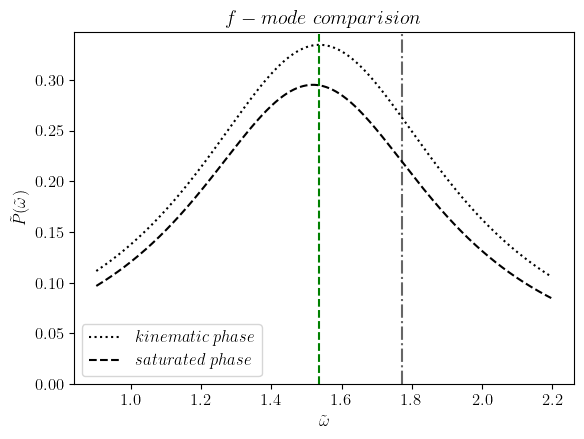

In [ ]:
i = 1
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4.55))

# ax.plot(om_f_kin, f_kin, ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ax.plot(om_f_sat, f_sat, ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
ax.plot(f_kin[i][0], f_kin[i][1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
ax.plot(f_sat[i][0], f_sat[i][1], ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
ax.axvline(x=f_om[i], ls='-.', c='k', alpha=0.6)
ax.axvline(x=para_f_kin[i][1], ls='--', c='g')
# ax.axvline(x=om_f_kin[indx_peak], ls='--', c='g')
# ax.axvline(x=para_f_sat_lor[1], ls='--', c='g')


plt.ylim(0,)
plt.legend()
plt.xlabel(r"$\tilde{\omega}$")
plt.ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.title(r"$f-mode$ $comparision$")
plt.tight_layout()
plt.show()